<a href="https://colab.research.google.com/github/RedDawe/Sorting_items_bough_together/blob/master/recommendermender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parts of code taken from:

https://www.kaggle.com/himansh96/eda-e-commerce-dataset

https://www.kaggle.com/johnosorio/retail-rocket-ecommerce-recommender-system

Load everything in

In [0]:
!pip install tensorflow-gpu==2.0

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"reddawe","key":"a973d3d754ed6eb75ff80b96461703d8"}'}

In [0]:
!mkdir ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d retailrocket/ecommerce-dataset

 99% 287M/291M [00:01<00:00, 143MB/s]
100% 291M/291M [00:02<00:00, 151MB/s]


In [0]:
!unzip ecommerce-dataset.zip

Archive:  ecommerce-dataset.zip
  inflating: category_tree.csv       
  inflating: events.csv              
  inflating: item_properties_part1.csv  
  inflating: item_properties_part2.csv  


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
assert tf.executing_eagerly()

In [0]:
events = pd.read_csv('events.csv')
category_tree = pd.read_csv('category_tree.csv')
items1 = pd.read_csv('item_properties_part1.csv')
items2 = pd.read_csv('item_properties_part2.csv')
items = pd.concat([items1, items2]) 

Quick visual

In [0]:
events.head(20)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
5,1433224086234,972639,view,22556,NaN
6,1433221923240,810725,view,443030,NaN
7,1433223291897,794181,view,439202,NaN
8,1433220899221,824915,view,428805,NaN
9,1433221204592,339335,view,82389,NaN


In [0]:
category_tree.head(6)

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
5,231,NaN


In [0]:
items.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [0]:
items['itemid'].unique().size

417053

In [0]:
events[events.event == 'transaction'].visitorid.sort_values().unique().size

11719

Too many items and too little bought items to simply softmax across all items.

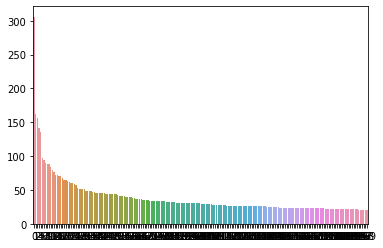

In [0]:
import operator
import seaborn as sns

grouped=events.groupby('event')['itemid'].apply(list)

#the most addtocart itemid
addtocart=grouped['addtocart']
count_addtocart={}
# for item in set(addtocart[:]):
#     #print(item)
#     count_addtocart[item]=addtocart.count(item)
addtocart=np.array(addtocart[:])
unique, counts = np.unique(addtocart, return_counts=True)
count_addtocart=dict(zip(unique, counts))

sorted_count_addtocart =sorted(count_addtocart.items(), key=operator.itemgetter(1),reverse=True)
x=[i for i in range(200)]
y=[i[1] for i in sorted_count_addtocart[:200]]
g=sns.barplot(x,y, order=x)

Maybe we can get the a few items with another technique and then rank them with logistic regression

In [0]:
# Firstly let's create an array that lists visitors who made a purchase
customer_purchased = events[events.transactionid.notnull()].visitorid.unique()
    
purchased_items = []
    
# Create another list that contains all their purchases 
for customer in customer_purchased:

    #Generate a Pandas series type object containing all the visitor's purchases and put them in the list
    purchased_items.append(list(events.loc[(events.visitorid == customer) & (events.transactionid.notnull())].itemid.values))   

In [0]:
customer_purchased[0:5]

array([599528, 121688, 552148, 102019, 189384])

In [0]:
purchased_items[0:5]

[[356475],
 [15335,
  380775,
  237753,
  317178,
  12836,
  400969,
  105792,
  25353,
  200793,
  80582,
  302422],
 [81345],
 [150318, 49521],
 [310791, 299044]]

In [0]:
# Write a function that would show items that were bought together (same of different dates) by the same customer
def recommender_bought_bought(item_id, purchased_items=purchased_items):
    
    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    
    #Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))
    
    return recommender_list

In [0]:
recommender_bought_bought(15335, purchased_items)

[105792, 200793, 12836, 80582, 380775, 400969, 25353, 302422, 237753, 317178]

Now let's rank the results

We only have a short viewing history and most often no buying history. So we can feed the whole history of the user into our model, but we don't have the recources the train a new model for every user, as opposed to developing a movie recommender for example.

In [0]:
X = []
Y = []
max_length = 0

for j, id in enumerate(customer_purchased):
  customer_lifeline = events[events.visitorid == id].sort_values('timestamp')
  lifeline = []
  lifeline_labels = []

  for _, event in customer_lifeline.iterrows():
    lifeline.append(event.itemid)
    lifeline_labels.append(1 if event.itemid in purchased_items[j] else 0)

  X.append(lifeline)
  Y.append(lifeline_labels)
  max_length = len(lifeline) if len(lifeline) > max_length else max_length

In [35]:
print(X[:5])

[[356475, 356475, 356475, 356475, 356475, 356475, 356475, 356475, 356475, 356475, 356475, 356475, 356475, 356475, 356475, 356475, 64279], [200793, 251525, 302422, 302422, 105792, 380775, 200793, 302422, 105792, 380775, 12836, 15335, 272926, 237753, 237753, 317178, 317178, 80582, 80582, 25353, 25353, 282803, 371390, 282803, 400969, 400969, 380775, 12836, 237753, 400969, 105792, 317178, 25353, 302422, 80582, 15335, 200793], [81345, 81345, 81345], [49521, 49521, 150318, 49521, 49521, 150318, 49521, 150318, 49521], [299044, 299044, 299044, 299044, 310791, 310791, 299044, 299044, 310791, 310791, 299044, 299044, 299044, 299044, 170811, 369447, 310791, 433397, 299044, 299044, 446507, 299044, 299044, 299044, 299044, 299044, 65722, 65722, 299044]]


In [0]:
print(len(X), len(Y))

11719 11719


In [0]:
print(len(purchased_items), len(customers_lifeline))

11719 11719


In [0]:
print(customer_purchased.shape)

(11719,)


In [0]:
def recall_m(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

In [0]:
inputs = tf.keras.Input([max_length])
model = tf.keras.layers.Embedding(items['itemid'].max(), 10, input_length=max_length)(inputs)
#model = tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)(model)
model = tf.keras.layers.LSTM(1, activation='sigmoid', return_sequences=True)(model)
model = tf.keras.Model(inputs=inputs, outputs=model)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 13, 10)            4668660   
_________________________________________________________________
lstm (LSTM)                  (None, 13, 1)             48        
Total params: 4,668,708
Trainable params: 4,668,708
Non-trainable params: 0
_________________________________________________________________


In [0]:
checkpoint_path = "training_0/cp.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 verbose=1)

In [0]:
model.fit(tf.keras.preprocessing.sequence.pad_sequences(X, max_length), tf.keras.preprocessing.sequence.pad_sequences(Y, max_length), epochs=10, validation_split=0.1, callbacks=[cp_callback])

Train on 10547 samples, validate on 1172 samples
Epoch 1/10
10528/10547 [============================>.] - ETA: 0s - loss: 0.5287 - accuracy: 0.6674 - f1_m: 0.2001
Epoch 00001: val_accuracy improved from -inf to 0.80618, saving model to training_0/cp.ckpt
10547/10547 [==============================] - 24s 2ms/sample - loss: 0.5284 - accuracy: 0.6677 - f1_m: 0.2019 - val_loss: 0.4001 - val_accuracy: 0.8062 - val_f1_m: 0.7500
Epoch 2/10
10528/10547 [============================>.] - ETA: 0s - loss: 0.3532 - accuracy: 0.8225 - f1_m: 0.7897
Epoch 00002: val_accuracy improved from 0.80618 to 0.82935, saving model to training_0/cp.ckpt
10547/10547 [==============================] - 22s 2ms/sample - loss: 0.3532 - accuracy: 0.8225 - f1_m: 0.7895 - val_loss: 0.3283 - val_accuracy: 0.8294 - val_f1_m: 0.7969
Epoch 3/10
10528/10547 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8525 - f1_m: 0.8229
Epoch 00003: val_accuracy did not improve from 0.82935
10547/10547 [=======

In [0]:
model.load_weights(checkpoint_path)

Metric are going to be far from perfect, since it's not that hard to learn that items that repeat for a user are more likely to be purchased by him. Hopefuly the model is also learning other useful stuff though.

In [0]:
def sorted_recomendations(users_past):
  options = recommender_bought_bought(users_past[-1])

  if options:
    to_be_predicted_matrix = []
    for option in options:
      to_be_predicted_matrix.append(users_past + [option])

    predictions = model.predict(tf.keras.preprocessing.sequence.pad_sequences(to_be_predicted_matrix, max_length))[:, -1, 0]

    return np.array(options)[np.flip(np.argsort(predictions))]

  else:
    return []

In [36]:
sorted_recomendations([200793, 251525, 302422, 302422, 105792, 380775, 200793, 302422, 105792, 380775, 12836, 15335, 272926, 237753, 237753, 317178, 317178, 80582, 80582, 25353, 25353, 282803, 371390, 282803, 400969, 400969, 380775, 12836, 237753, 400969, 105792, 317178, 25353, 302422, 80582, 15335, 200793])

array([302422, 237753,  15335,  80582, 400969, 105792, 380775, 317178,
        25353,  12836])